This tutorial aims to examine and understand how the *sample weights* work in the random forest model in `scikit-learn` library.

**Assumptions**: *Sample weights* may affect the follow process:

- bootstrap sampling

    - not affected

    - sample weights do **NOT** affected the bootstrapping probability

- loss function (splitting criterion): 

    - affected

    - sample weights **DO** affect the loss function, i.e., splitting criterion, of decision tree
    
- out-of-bag score

    - not affected

    - sample weights do **NOT** affect the estimation of oob score


In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.style.use('default')

from utils.model_measure import print_regression_measure

# 1. Dataset

a regression dataset

In [14]:
from sklearn.datasets import load_diabetes
data_X, data_Y = load_diabetes(return_X_y=True, as_frame=False)


n_samples = len(data_X)

# sample weights
rng = np.random.default_rng(seed=42)
data_weight = rng.normal(loc=0.0, scale=1.0, size=n_samples)
data_weight = np.abs(data_weight) + 1.0

train_idx, test_idx = train_test_split(range(n_samples), test_size=0.3, random_state=0)
train_X, test_X = data_X[train_idx], data_X[test_idx]
train_Y, test_Y = data_Y[train_idx], data_Y[test_idx]
train_weight, test_weight = data_weight[train_idx], data_weight[test_idx]

print('\nShape of dataset:', data_X.shape, data_Y.shape, data_weight.shape,
      '\nShape of training set:', train_X.shape, train_Y.shape, train_weight.shape,
      '\nShape of testing set:', test_X.shape, test_Y.shape, test_weight.shape)


Shape of dataset: (442, 10) (442,) (442,) 
Shape of training set: (309, 10) (309,) (309,) 
Shape of testing set: (133, 10) (133,) (133,)


Text(0.5, 1.0, 'Distribution of target')

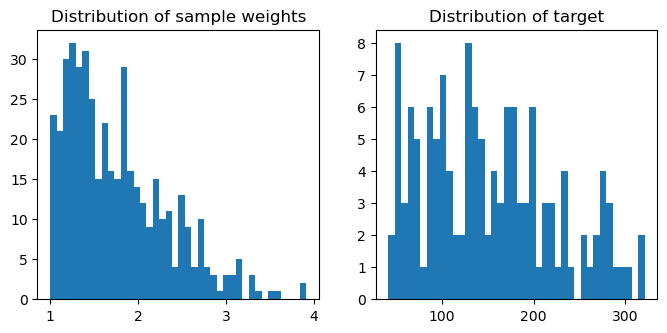

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

ax = axes[0]
ax.hist(data_weight, bins=40)
ax.set_title('Distribution of sample weights')

ax = axes[1]
ax.hist(test_Y, bins=40)
ax.set_title('Distribution of target')

# 2. Splitting criterion

The most used criteria for RF regression includes: 

- squared error: `criterion=squared_error`

    - explained in `sklearn.metrics.mean_squared_error`

- poisson deviance: `criterion=poisson`

    - explained in `sklearn.metrics.mean_poisson_deviance`

The deviance of a node is defined as:

$$
\begin{aligned}
\text{Unweighted samples:} & & D(y) = \frac{1}{N} \sum_{i=1}^N L(y_i, \bar{y})
\\
\text{Weighted samples:} & & D(y) = \dfrac{\sum_{i=1}^N w_i \, L(y_i, \bar{y}) }{\sum_{i=1}^N w_i}
\end{aligned}
$$

where $\bar_{y}$ represent sample mean, and it incorporates sample weights if provided, i.e.,

$$
\begin{aligned}
\text{Unweighted samples:} & & \bar{y} = \frac{1}{N} \sum_{i=1}^N y_i
\\
\text{Weighted samples:} & & \bar{y} = \dfrac{\sum_{i=1}^N w_i \, y_i}{\sum_{i=1}^N w_i}
\end{aligned}
$$


In [16]:
def compute_deviance(arr, criterion='mse', weights=None):
    
    # weighted mean of sample sets
    arr_mean = np.average(arr, weights=weights)
    
    if criterion.lower() in ['mean_squared_error', 'mse']:
        dev = np.square(arr - arr_mean)
    
    elif criterion.lower() in ['mean_poisson_deviance', 'mpd']:
        dev = 2 * arr * np.log(arr / arr_mean) + arr_mean - arr
    
    # weighted mean of samples' deviance
    criterion = np.average(dev, weights=weights)
    return criterion

In [17]:
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

arr = np.arange(1, 101)
n_smaples = len(arr)

arr_weight = np.random.random(n_smaples) * 100
arr_mean   = np.average(arr)
arr_wmean  = np.average(arr, weights=arr_weight)

print('\nUnweighted Mean:', arr_mean, 
      '\n  Weighted mean:', arr_wmean)

print('\nScikit learn:',
      '\nUnweighted MSE:', mean_squared_error(arr, np.broadcast_to(arr_mean, arr.shape)),
      '\n  Weighted MSE:', mean_squared_error(arr, np.broadcast_to(arr_wmean, arr.shape), sample_weight=arr_weight),
      '\nUnweighted MPD:', mean_poisson_deviance(arr, np.broadcast_to(arr_mean, arr.shape)),
      '\n  Weighted MPD:', mean_poisson_deviance(arr, np.broadcast_to(arr_wmean, arr.shape), sample_weight=arr_weight),
      '\nOwn coding:',
      '\nUnweighted MSE:', compute_deviance(arr, criterion='mse'),
      '\n  Weighted MSE:', compute_deviance(arr, criterion='mse', weights=arr_weight),
      '\nUnweighted MPD:', compute_deviance(arr, criterion='mpd'),
      '\n  Weighted MPD:', compute_deviance(arr, criterion='mpd', weights=arr_weight), )


Unweighted Mean: 50.5 
  Weighted mean: 49.727466853449556

Scikit learn: 
Unweighted MSE: 833.25 
  Weighted MSE: 871.8463446070915 
Unweighted MPD: 19.01553219634623 
  Weighted MPD: 20.116184399969008 
Own coding: 
Unweighted MSE: 833.25 
  Weighted MSE: 871.8463446070915 
Unweighted MPD: 19.01553219634623 
  Weighted MPD: 20.116184399968997


# 3. Decision tree

In [18]:
model = DecisionTreeRegressor(
    criterion='squared_error', splitter='best', random_state=0, max_depth=4, min_samples_split=5)

model.fit(train_X, train_Y)
data_Y_pred = model.predict(data_X)
test_Y_pred = model.predict(test_X)

print_regression_measure(test_Y, test_Y_pred)

 MAE : 51.926
 MSE : 4337.125
MAPE : 0.441
  R2 : 0.15


[Text(0.5267857142857143, 0.9, 'x[8] <= 0.022\nsquared_error = 6286.442\nsamples = 309\nvalue = 152.12'),
 Text(0.2857142857142857, 0.7, 'x[2] <= 0.005\nsquared_error = 4311.323\nsamples = 212\nvalue = 121.892'),
 Text(0.14285714285714285, 0.5, 'x[6] <= 0.021\nsquared_error = 2566.526\nsamples = 157\nvalue = 103.369'),
 Text(0.07142857142857142, 0.3, 'x[8] <= -0.043\nsquared_error = 3210.45\nsamples = 90\nvalue = 118.489'),
 Text(0.03571428571428571, 0.1, 'squared_error = 1964.604\nsamples = 24\nvalue = 86.25'),
 Text(0.10714285714285714, 0.1, 'squared_error = 3148.107\nsamples = 66\nvalue = 130.212'),
 Text(0.21428571428571427, 0.3, 'x[6] <= 0.17\nsquared_error = 981.996\nsamples = 67\nvalue = 83.06'),
 Text(0.17857142857142858, 0.1, 'squared_error = 880.615\nsamples = 66\nvalue = 81.742'),
 Text(0.25, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 170.0'),
 Text(0.42857142857142855, 0.5, 'x[3] <= 0.024\nsquared_error = 5517.162\nsamples = 55\nvalue = 174.764'),
 Text(0.3571428571428

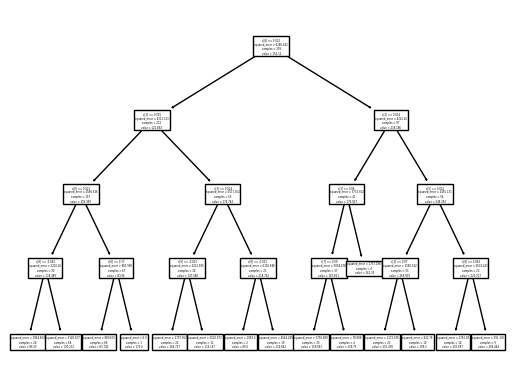

In [19]:
plot_tree(model)
# plt.savefig('tree_weighted_samples.jpg', dpi=600)
# plt.savefig('tree.jpg', dpi=600)

# 4. Random forest

In [2]:
import tqdm
import sklearn
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## 4.1 Bootstrap

Aims to explore whether the sample weights affect boostrap sampling

In [3]:
# extreme case
train_weight_t = np.zeros_like(train_Y)
train_weight_t[:10] = 1.

# weighted model
model_w = RandomForestRegressor(n_estimators=100, random_state=None)
model_w.fit(train_X, train_Y, train_weight_t)

sample_freq_w = pd.Series(np.concatenate(model_w.estimators_samples_)).value_counts().sort_index()
sample_freq_w.name = 'Weighted'

# unweighted model
model_u = RandomForestRegressor(n_estimators=100, random_state=None)
model_u.fit(train_X, train_Y)

sample_freq_u = pd.Series(np.concatenate(model_u.estimators_samples_)).value_counts().sort_index()
sample_freq_u.name = 'Unweighted'

sample_freq = pd.concat([sample_freq_w, sample_freq_u], axis=1)
sample_freq

sample_freq.plot(xlabel='Sample index', ylabel='Frequency')

NameError: name 'train_Y' is not defined

## 4.2 Out-of-bag scores

Computation of oob scores based on oob prediction (`.oob_prediction_`).

#### OOB prediction

For each submodel (i.e., decision tree), predict the output for oob samples separately. For example

|          | Submodel 1 | Submodel 2 | Submodel 3 | Submodel 4 |
|----------|------------|------------|------------|------------|
| Sample 1 | V          | $y_{12}$   | V          | $y_{14}$   |
| Sample 2 | $y_{21}$   | $y_{22}$   | $y_{23}$   | V          |
| Sample 3 | V          | $y_{32}$   | $y_{33}$   | V          |

- "V" indicates the in-bag sample, i.e., the sample is used for the associated submodel

- $y_{21}$ the out-of-bag prediction of sample 2 from submodel 1

Finally, take average of all out-of-bag prediction, i.e.,

$$
\hat_{y}^{oob}_1 = \frac{y_{12} + y_{14}}{2} \\
\hat_{y}^{oob}_2= \frac{y_{21} + y_{22} + y_{23}}{3} \\
\cdots
$$

#### OOB score

The oob score is computed based the regular metric functions on the differences between oob predicted results and true values

OOB score **NOT** include sample weights


In [356]:
def compute_oob_prediction(model, data_X):
    # number of samples
    n_samples = len(data_X)
    n_estimators = model.get_params()['n_estimators']

    sample_used_idx = model.estimators_samples_
    oob_idx = [np.setdiff1d(np.arange(n_samples), idx) for idx in sample_used_idx]
    
    oob_pred = np.empty((n_samples, n_estimators))
    oob_pred.fill(np.nan)
    
    for model_idx, (oob_id, submodel) in enumerate(zip(oob_idx, model.estimators_)):
        # print(model_idx, oob_id)
        oob_X = data_X[oob_id]
        oob_Y_pred = submodel.predict(oob_X)
        
        oob_pred[oob_id, model_idx] = oob_Y_pred
    
    # nan number will be ignore
    oob_pred = np.nanmean(oob_pred, axis=1)
    
    return oob_pred

In [360]:
sample_weight = train_weight

metric_func = model.get_params()['oob_score']

train_Y_oob_pred = model.oob_prediction_

print('Error for oob prediction:', train_Y_oob_pred - compute_oob_prediction(model, train_X))

print('\nOob score (MSE):', model.oob_score_,
      '\nOob score (MSE) without sample weights:', metric_func(train_Y, train_Y_oob_pred, sample_weight=None),
      '\nOob score (MSE) with sample weights:', metric_func(train_Y, train_Y_oob_pred, sample_weight=train_weight))

Error for oob prediction: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Oob score (MSE): 3302.1608919165